# NLP Going Deeper 6 임베딩 내 편향성 알아보기 - Project
- 모든 장르 간 편향성 측정해 보기 : 코메디 - 드라마 축을 이용

### 2023-01-25 (수)

## 라이브러리 버전 확인

In [32]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

### Read Text Data

In [33]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


### Tokenize

In [57]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [35]:
from konlpy.tag import Okt

okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


## STEP 2. 추출된 결과로 embedding model 만들기

In [126]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8770405650138855),
 ('다큐멘터리', 0.8483660221099854),
 ('드라마', 0.8000491857528687),
 ('영화로', 0.7947264909744263),
 ('코미디', 0.7801400423049927),
 ('영상', 0.7622635960578918),
 ('주제', 0.7590945363044739),
 ('형식', 0.757409930229187),
 ('소재', 0.756905198097229),
 ('실화', 0.7543736100196838)]

## STEP 3. target, attribute 단어 셋 만들기

### target

In [128]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

comedy_txt = 'synopsis_art.txt'
drama_txt = 'synopsis_gen.txt'

In [38]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
comedy = read_token(comedy_txt)
drama = read_token(drama_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [129]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([comedy, drama])

print(X.shape)

(2, 41082)


In [130]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[24574])

23976
온통


In [131]:
m1 = X[0].tocoo()   # comedy를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # drama을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #comedy term, TF-IDF Descending
w2.sort(key=lambda x: x[1], reverse=True)   #drama term

print('코메디 대표 단어:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')
print('')
print('드라마 대표 단어:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

코메디 대표 단어:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 
드라마 대표 단어:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

#### 대표 단어 추출

In [132]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 코메디를 대표하는 단어 15개 추출
target_comedy, target_drama = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_comedy.append(w1_[i])
    if len(target_comedy) == n: break 
        
# w2에만 있고 w1에는 없는, 드라마를 대표하는 단어 15개
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_drama.append(w2_[i])
    if len(target_drama) == n: break

print('코메디 대표 단어 :')
print(target_comedy)
print()
print('드라마 대표 단어 :')
print(target_drama)

코메디 대표 단어 :
['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']

드라마 대표 단어 :
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


### attribute

In [136]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_art.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_gen.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '예술', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '일반', '판타지']

In [137]:
len(genre_txt)

21

In [139]:
len(genre_name)

21

In [140]:
import time

genre = []

for file_name in genre_txt:
    start = time.time()
    genre.append(read_token(file_name))
    print(time.time() - start)

synopsis_SF.txt 파일을 읽고 있습니다.
11.433146476745605
synopsis_family.txt 파일을 읽고 있습니다.
4.410401105880737
synopsis_show.txt 파일을 읽고 있습니다.
4.671892881393433
synopsis_horror.txt 파일을 읽고 있습니다.
32.7008261680603
synopsis_etc.txt 파일을 읽고 있습니다.
28.068148374557495
synopsis_documentary.txt 파일을 읽고 있습니다.
88.81182098388672
synopsis_art.txt 파일을 읽고 있습니다.
114.00987577438354
synopsis_romance.txt 파일을 읽고 있습니다.
55.87590312957764
synopsis_musical.txt 파일을 읽고 있습니다.
1.8985390663146973
synopsis_mystery.txt 파일을 읽고 있습니다.
8.22351861000061
synopsis_crime.txt 파일을 읽고 있습니다.
15.259371042251587
synopsis_historical.txt 파일을 읽고 있습니다.
1.6944172382354736
synopsis_western.txt 파일을 읽고 있습니다.
0.46701812744140625
synopsis_adult.txt 파일을 읽고 있습니다.
27.1467387676239
synopsis_thriller.txt 파일을 읽고 있습니다.
23.719440460205078
synopsis_animation.txt 파일을 읽고 있습니다.
70.75592088699341
synopsis_action.txt 파일을 읽고 있습니다.
60.63331913948059
synopsis_adventure.txt 파일을 읽고 있습니다.
5.320523262023926
synopsis_war.txt 파일을 읽고 있습니다.
4.5948991775512695
synopsis_gen.txt 파일을

In [141]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42302)


In [142]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아버지, 시작, 그녀, 아주르, 아들, 마을, 국제, 할머니, 
공연: 오페라, 사랑, 실황, 토스카, 자신, 올레, 카바, 그녀, 공연, 백작, 프레, 위해, 리골레토, 왕자, 오텔로, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
예술: 그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 그녀, 에스메랄다, 음악, 충무로, 모차르트, 영화, 자신, 카바, 영화제, 바흐, 니웨, 토스카, 모도, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 사랑, 자신, 신기전, 황제, 그녀, 아가멤논, 최고, 운명, 사람, 루안, 전쟁, 트로이, 
서부극(웨스턴): 서부, 보안관, 위해, 카우보이, 벌린, 그레이프바인, 헨리, 마을, 자신, 아이, 개릿, 시작, 무법자, 태구, 현상금, 
성인물(에로): 그녀, 남편, 자신, 마사지, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작,

## STEP 4. WEAT score 계산과 시각화

In [143]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


In [144]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [145]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [147]:
X = np.array([model.wv[word] for word in target_comedy])
Y = np.array([model.wv[word] for word in target_drama])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [148]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.54989934
SF 공연 -0.48629734
SF 공포(호러) -0.6921083
SF 기타 0.36229536
SF 다큐멘터리 0.6028883
SF 예술 -0.70664835
SF 멜로로맨스 -0.81196576
SF 뮤지컬 0.3348755
SF 미스터리 -0.73344445
SF 범죄 -0.29291138
SF 사극 -0.8449185
SF 서부극(웨스턴) -0.425689
SF 성인물(에로) -0.59070516
SF 스릴러 -0.5620838
SF 애니메이션 0.37878442
SF 액션 -0.5058523
SF 어드벤처 -0.73919666
SF 전쟁 0.23325811
SF 일반 -0.053405296
SF 판타지 -0.17995892
가족 공연 0.13682577
가족 공포(호러) -0.11589206
가족 기타 0.7774739
가족 다큐멘터리 0.86145604
가족 예술 -0.092279114
가족 멜로로맨스 -0.58953273
가족 뮤지컬 0.72255605
가족 미스터리 -0.31601492
가족 범죄 0.20915726
가족 사극 -0.0028923114
가족 서부극(웨스턴) 0.47855815
가족 성인물(에로) -0.28008366
가족 스릴러 -0.12583266
가족 애니메이션 0.8954677
가족 액션 0.12363983
가족 어드벤처 0.107070275
가족 전쟁 0.6709125
가족 일반 0.530862
가족 판타지 0.49071345
공연 공포(호러) -0.18882665
공연 기타 0.9747349
공연 다큐멘터리 0.9608908
공연 예술 -0.2135003
공연 멜로로맨스 -0.67863566
공연 뮤지컬 0.91761017
공연 미스터리 -0.34509948
공연 범죄 0.11017796
공연 사극 -0.21410684
공연 서부극(웨스턴) 0.19435598
공연 성인물(에로) -0.42234543
공연 스릴러 -0.18656744
공연 애니메이션 0.9899114
공연 액션 0.0

<AxesSubplot:>

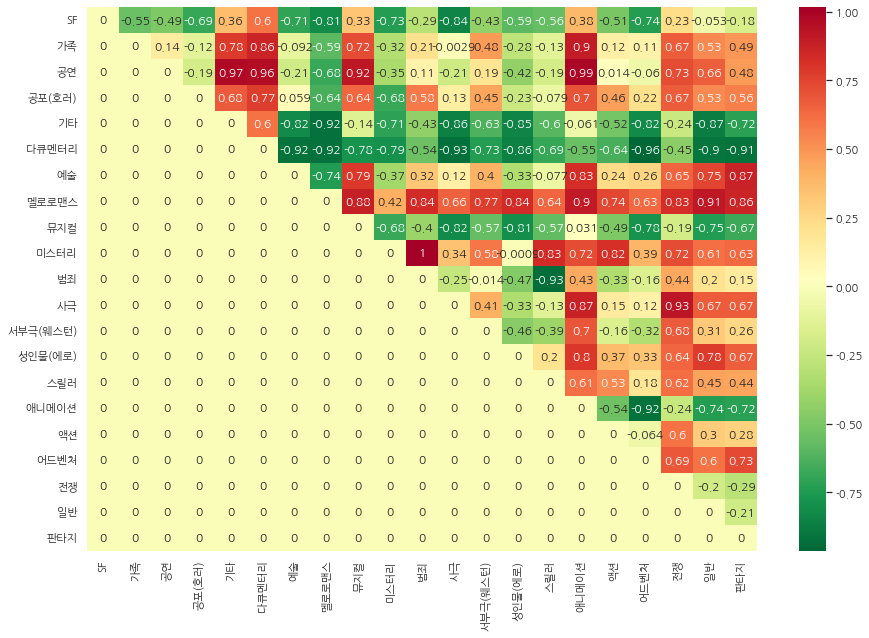

In [150]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (15,10))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### 고찰

1. 타겟 X축은 코메디, Y축은 드라마로 설정하여 실험을 진행하였다.  
2. 속성 A, B에 각 장르를 조합하여 설정하였다.  
3. WEAT 점수가 0.8 이상이거나, -0.8 이하인 경우만 해석의 대상으로 하였다.  
    - 코메디와 드라마, 가족영화와 다큐멘타리의 WEAT 점수는 0.86이었다.  
     : 해석해 보면, 가족 영화는 코메디에 가깝고, 다큐멘타리는 드라마에 가깝다고 할 수 있다.  
    - 코메디와 드라마, 가족영화와 애니메이션의 WEAT 점수는 0.9이었다.  
     : 해석해 보면, 가족 영화는 코메디에 가깝고, 애니메이션은 드라마에 가깝다고 할 수 있다.
     : 애니메이션은 대부분 장르와 비교했을 때 드라마에 가까웠다. 아마도 애니메이션의 줄거리 특성이 드라마와 비슷하기 때문일 것이라고 생각되었다.
    - 공연 영화는 여러 장르와 비교해 보았을 때 코메디에 가까웠다.
    - 다큐멘타리는 다른 모든 장르와 비교했을 때 일관되게 드라마에 가까웠다. 
    - 반면 멜로 로멘스는 다른 모든 장르와 비교했을 때 일관되게 코메디에 가까웠다.
    